[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


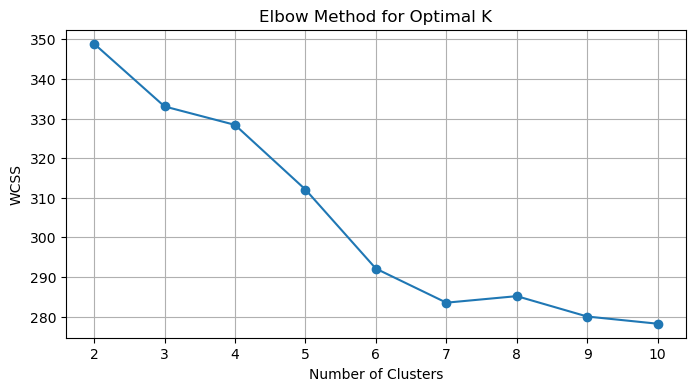

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df = pd.read_csv("naukri_dataanalyst_scraped.csv")
df.dropna(subset=['Description'], inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)
df["Cleaned_Description"] = df["Description"].apply(clean_text)
tfidf = TfidfVectorizer(max_df=0.9, min_df=5)
X = tfidf.fit_transform(df["Cleaned_Description"])

wcss = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


In [7]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)
def print_top_keywords(model, vectorizer, top_n=10):
    terms = vectorizer.get_feature_names_out()
    for i, center in enumerate(model.cluster_centers_):
        print(f"\n Cluster {i} top terms:")
        top_indices = center.argsort()[-top_n:][::-1]
        print(", ".join([terms[ind] for ind in top_indices]))

print_top_keywords(kmeans, tfidf)

cluster_names = {
    0: "Python & ML Roles",
    1: "Power BI + Excel Jobs",
    2: "SQL + Database Jobs",
    3: "Generic Analyst Jobs"
}

df["Cluster_Label"] = df["Cluster"].map(cluster_names)




 Cluster 0 top terms:
analyst, data, looking, team, join, dynamic, embark, work, job, must

 Cluster 1 top terms:
experience, years, data, analysis, knowledge, sql, strong, minimum, analyst, candidate

 Cluster 2 top terms:
data, science, degree, role, computer, bachelors, purpose, statistics, information, mathematics

 Cluster 3 top terms:
skills, required, qualifications, bachelors, communication, degree, data, sql, strong, economics


In [10]:
df_sorted = df.sort_values(by="Cluster")
df_sorted[["Experience", "Location", "Description", "Cluster", "Cluster_Label"]].to_csv(
    "clustered_job_postings_with_labels.csv", index=False
)
print("Final labeled dataset saved as 'clustered_job_postings_with_labels.csv'")


Final labeled dataset saved as 'clustered_job_postings_with_labels.csv'


In [11]:
from collections import Counter
cluster_keywords = {}

for cluster in sorted(df['Cluster'].unique()):
    cluster_text = df[df['Cluster'] == cluster]['Cleaned_Description'].str.cat(sep=' ')
    word_list = cluster_text.split()
    common_words = Counter(word_list).most_common(15)
    cluster_keywords[cluster] = common_words

In [17]:
for cluster, keywords in cluster_keywords.items():
    label = df[df['Cluster'] == cluster]['Cluster_Label'].iloc[0]
    print(f"\n Cluster {cluster} - {label} - Top Words:")
    for word, freq in keywords:
        print(f"{word}: {freq}")


 Cluster 0 - Python & ML Roles - Top Words:
data: 99
analyst: 66
team: 49
looking: 46
join: 42
dynamic: 31
embark: 18
work: 17
job: 14
must: 11
ability: 10
good: 9
working: 8
sql: 8
financial: 8

 Cluster 1 - Power BI + Excel Jobs - Top Words:
experience: 77
years: 45
data: 43
sql: 12
analysis: 12
strong: 11
analyst: 11
knowledge: 9
minimum: 8
candidate: 8
power: 7
role: 7
working: 7
analytics: 7
tools: 6

 Cluster 2 - SQL + Database Jobs - Top Words:
data: 114
science: 46
degree: 43
role: 39
computer: 34
bachelors: 28
purpose: 24
statistics: 22
information: 21
interpret: 18
mathematics: 16
bachelor: 15
turn: 13
analysis: 10
related: 10

 Cluster 3 - Generic Analyst Jobs - Top Words:
skills: 33
required: 22
data: 15
bachelors: 14
degree: 13
qualifications: 13
communication: 8
strong: 7
sql: 7
minimum: 4
finance: 4
economics: 4
proficiency: 4
analyst: 4
good: 4


In [13]:
rows = []
for cluster, keywords in cluster_keywords.items():
    label = df[df['Cluster'] == cluster]['Cluster_Label'].iloc[0]
    for word, freq in keywords:
        rows.append({
            'Cluster': cluster,
            'Cluster_Label': label,
            'Word': word,
            'Frequency': freq
        })

top_words_df = pd.DataFrame(rows)
top_words_df.to_csv("top_words_per_cluster.csv", index=False)
print("\n saved as 'top_words_per_cluster.csv'")


 saved as 'top_words_per_cluster.csv'


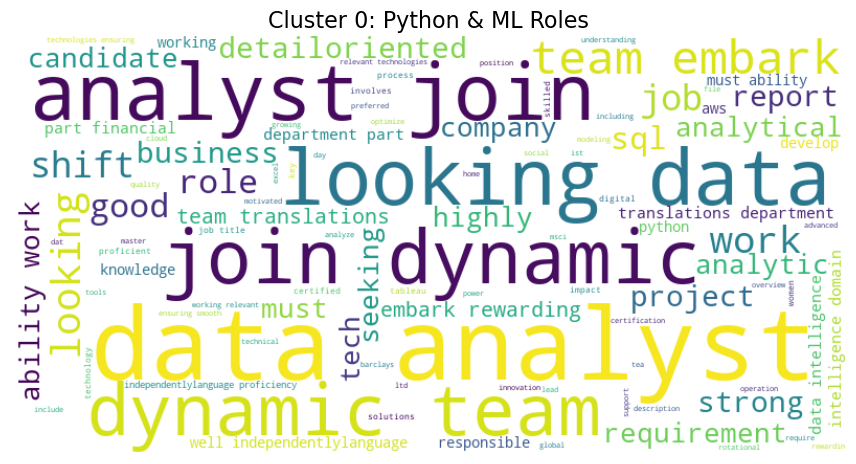

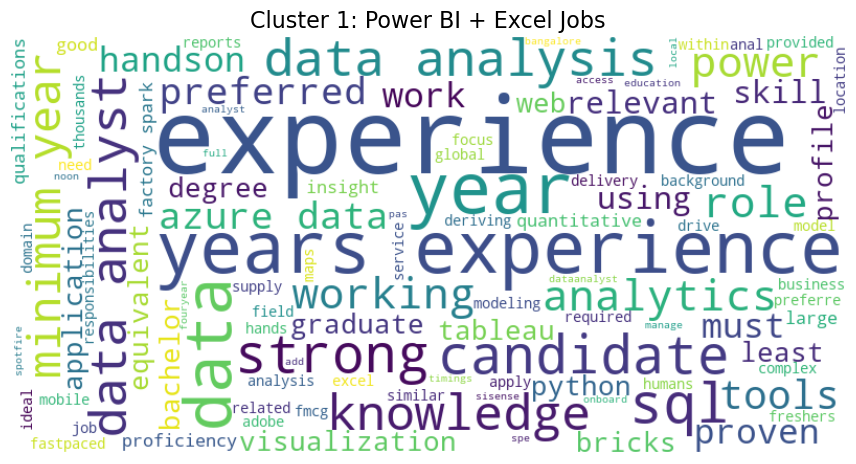

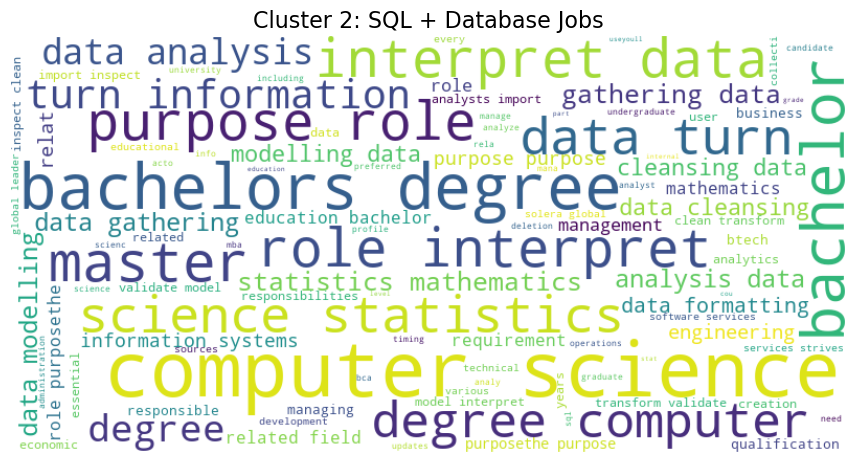

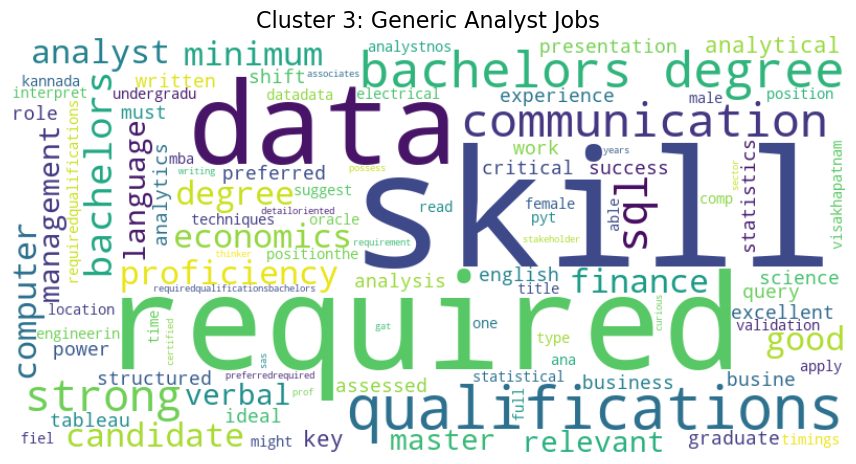

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-muted")
unique_clusters = sorted(df['Cluster'].unique())
for cluster in unique_clusters:
    cluster_df = df[df['Cluster'] == cluster]
    label = cluster_df['Cluster_Label'].iloc[0]
    
    text = cluster_df['Cleaned_Description'].str.cat(sep=' ')
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster}: {label}", fontsize=16)
    plt.tight_layout(pad=2)
    plt.show()


In [20]:

df_jobs = pd.read_csv("clustered_job_postings_with_labels.csv")
df_top_words = pd.read_csv("top_words_per_cluster.csv")

top_words_agg = df_top_words.groupby('Cluster').agg({'Word': lambda x: ', '.join(x)}).reset_index()


df_merged = df_jobs.merge(top_words_agg, on='Cluster', how='left')

df_merged.to_csv("jobs_with_top_words.csv", index=False)

print("'jobs_with_top_words.csv'")


'jobs_with_top_words.csv'
